[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/inogs/arco-ocean/blob/main/tutorials/oni.ipynb)


# Computing the Oceanic El Nino Index (ONI) with Xarray and ARCO-OCEAN

This notebook has been adapted from another by [Climatematch](https://comptools.climatematch.io/), you can find the original [here](https://comptools.climatematch.io/tutorials/W1D2_Ocean-AtmosphereReanalysis/student/W1D2_Tutorial1.html#video-1-el-nino-southern-oscillation). All credit for the original content goes to the authors.

Climatematch credit: Abigail Bodner, Momme Hell, Aurora Basinski, Yosemley Bermúdez, Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Paul Heubel, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Chi Zhang, Ohad Zivan, Paul Heubel, Jenna Pearson, Chi Zhang, Ohad Zivan, Wesley Banfield, Paul Heubel, Jenna Pearson, Konstantine Tsafatinos, Chi Zhang, Ohad Zivan

## Tutorial Objectives

*Estimated timing of tutorial:* 20 mins

In this notebook, you will practice using XArray to examine sea surface temperature (SST) from the [ARCO-OCEAN dataset](https://github.com/inogs/arco-ocean), and explore variations in the climate system that occur during El Niño and La Niña events. You will learn to:

1. Load sea surface temperature data and its climatology from the ARCO-OCEAN dataset.
2. Select data using `.sel()`.
4. Use `.rolling()` to compute moving average.
5. Compute and plot the Oceanic Niño Index.

After completing the tasks above, you should be able to plot the [Oceanic Niño Index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) that looks similar to the figure below. The red and blue regions correspond to the phases of El Niño and La Niña, respectively.

![ONI index plot from NCAR Climate Data Guide](https://climatedataguide.ucar.edu/sites/default/files/styles/extra_large/public/2022-03/indices_oni_2_2_lg.png)

Credit: [NCAR](https://climatedataguide.ucar.edu/sites/default/files/styles/extra_large/public/2022-03/indices_oni_2_2_lg.png)

In [1]:
%pip install xarray numpy zarr obstore matplotlib cartopy cftime nc-time-axis dask distributed

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import zarr
import obstore

from typing import Literal
from dask.distributed import LocalCluster, Client

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
cluster

LocalCluster(197404c0, 'tcp://127.0.0.1:41945', workers=4, threads=8, memory=30.08 GiB)

In [4]:
client = Client(address=cluster.scheduler_address)
client

<Client: 'tcp://127.0.0.1:41945' processes=4 threads=8, memory=30.08 GiB>

In [5]:
%config InlineBackend.figure_format = 'retina'

## Introduction to El Niño Southern Oscillation (ENSO)

The geographic region between **5ºN-5ºS and 190ºE-240ºE (or 170ºW-120ºW)**, known as the **Niño 3.4 region**, is in the tropical Pacific Ocean and is commonly used as a metric for determining the phase of the El Niño-Southern Oscillation (ENSO). ENSO is a recurring climate pattern involving changes in sea surface temperature (SST) in the central and eastern tropical Pacific Ocean, which has two alternating phases:

- **El Niño:** the phase of ENSO characterized by warmer than average SSTs in the central and eastern tropical Pacific Ocean, weakened east-to-west equatorial winds, and increased rainfall in the eastern tropical Pacific.
- **La Niña:** the phase of ENSO which is characterized by cooler than average SSTs in the central and eastern tropical Pacific Ocean, stronger east-to-west equatorial winds, and decreased rainfall in the eastern tropical Pacific.

This Niño 3.4 region is the most representative of the ENSO phenomenon (cf. [Barnston et al. 1997](https://doi.org/10.1080/07055900.1997.9649597)) and therefore state-of-the-art. Regions 1 to 4 have been historical choices however are still used for historical comparisons and to investigate certain features of the [multifaceted ENSO](https://www.climate.gov/news-features/blogs/enso/why-are-there-so-many-enso-indexes-instead-just-one).

## Calculate the Oceanic Niño Index


To calculate the [Oceanic Niño Index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) (ONI) you will:

1.  Select SST data and daily climatology from Niño 3.4 region of 5ºN - 5ºS and 190ºE - 240ºE (or 170ºW - 120ºW) shown in the figure below.
2.  Compute the daily anomaly and its area-weighted mean for the Niño 3.4 region to obtain a time series.
3.  Smooth the time series with a 90 days (3-month) running mean.

![](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif)

## Open the SST Data

The ARCO-OCEAN dataset is distributed via S3, but here we'll load a local copy.

In [6]:
def open_dataset(which: Literal['dataset', 'climatology', 'mean', 'std', 'diff'], tres='1d', res='0p25', levels='10', region='eu-south-1', **kwargs) -> xr.Dataset:
    if which == 'dataset':
        bucket_name = 'ogs-arco-ocean/dataset'
    else:
        bucket_name = f"ogs-arco-ocean/stats={which}"
    bucket_name += f"/tres={tres}/res={res}/levels={levels}"
    s3_store = obstore.store.S3Store(bucket_name, skip_signature=True, region=region)
    store = zarr.storage.ObjectStore(store=s3_store, read_only=True)
    dataset = xr.open_dataset(store, engine='zarr', **kwargs)

    return dataset

In [7]:
arco_ocean = open_dataset(which='dataset')
arco_ocean

<xarray.Dataset> Size: 3TB
Dimensions:         (time: 10408, lat: 721, lon: 1440, level: 10)
Coordinates:
  * time            (time) datetime64[ns] 83kB 1993-01-01 ... 2021-06-30
  * lat             (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon             (lon) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * level           (level) int64 80B 0 4 8 12 16 20 24 28 32 34
    depth           (level) float32 40B ...
Data variables: (12/33)
    10u             (time, lat, lon) float32 43GB ...
    10v             (time, lat, lon) float32 43GB ...
    2d              (time, lat, lon) float32 43GB ...
    2t              (time, lat, lon) float32 43GB ...
    deptho          (lat, lon) float32 4MB ...
    dis24           (time, lat, lon) float32 43GB ...
    ...              ...
    vsd             (time, lat, lon) float32 43GB ...
    vsi             (time, lat, lon) float32 43GB ...
    waverys_deptho  (lat, lon) float32 4MB ...
    waverys_mask    (lat, lon) bool 1MB ...
    z               (lat, lon) float32 4MB ...
    zos             (time, lat, lon) float32 43GB ...
Attributes:
    last_updated:           2025-07-24 01:57:38.085536+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-07-18

In [8]:
climatology = open_dataset(which='climatology')
climatology

<xarray.Dataset> Size: 92GB
Dimensions:    (dayofyear: 365, lat: 721, lon: 1440, level: 10)
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon        (lon) float32 6kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * level      (level) int64 80B 0 4 8 12 16 20 24 28 32 34
    depth      (level) float32 40B ...
Data variables: (12/25)
    10u        (dayofyear, lat, lon) float32 2GB ...
    10v        (dayofyear, lat, lon) float32 2GB ...
    2d         (dayofyear, lat, lon) float32 2GB ...
    2t         (dayofyear, lat, lon) float32 2GB ...
    dis24      (dayofyear, lat, lon) float32 2GB ...
    i10fg      (dayofyear, lat, lon) float32 2GB ...
    ...         ...
    usd        (dayofyear, lat, lon) float32 2GB ...
    usi        (dayofyear, lat, lon) float32 2GB ...
    vo         (dayofyear, level, lat, lon) float32 15GB ...
    vsd        (dayofyear, lat, lon) float32 2GB ...
    vsi        (dayofyear, lat, lon) float32 2GB ...
    zos        (dayofyear, lat, lon) float32 2GB ...

First, open the SST and climatology datasets. At the end we will compute the anomaly and use Xarray's [`.merge()`](https://docs.xarray.dev/en/stable/generated/xarray.merge.html) method to combine them into a single dataset:


In [9]:
def get_sst(ds: xr.Dataset) -> xr.DataArray:
    ds = ds.rename(thetao='sst')
    da = ds['sst'].isel(level=0, drop=True)
    return da

In [10]:
sst = get_sst(arco_ocean)
# The climatology is computed using the '365_day' calendar, hence we drop the 29th of Febrary from sst
sst = sst.convert_calendar('365_day')
sst = sst.chunk(time=1)
sst

<xarray.DataArray 'sst' (time: 10401, lat: 721, lon: 1440)> Size: 43GB
dask.array<xarray-<this-array>, shape=(10401, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 83kB 1993-01-01 00:00:00 ... 2021-06-30 00:00:00
  * lat      (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C
    valid_max:      21306
    valid_min:      -32766

Ideally, we would like to compute the anomaly with something like

```python
sst_anomaly = sst - sst_climatology
```

But the two dataset have different time dimensions, and the (daily) climatology have to be replicated (tiled) before being used in the definition of the anomaly. Notice how this is done automagically by the `.sel` method.

In [11]:
sst_climatology = get_sst(climatology)
sst_climatology = sst_climatology.sel(dayofyear=sst.time.dt.dayofyear)
sst_climatology = sst_climatology.drop_vars('dayofyear')
sst_climatology = sst_climatology.chunk(time=1)
sst_climatology

<xarray.DataArray 'sst' (time: 10401, lat: 721, lon: 1440)> Size: 43GB
dask.array<xarray-<this-array>, shape=(10401, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 83kB 1993-01-01 00:00:00 ... 2021-06-30 00:00:00
  * lat      (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

In [12]:
sst_anomaly = sst - sst_climatology
sst_anomaly

<xarray.DataArray 'sst' (time: 10401, lat: 721, lon: 1440)> Size: 43GB
dask.array<sub, shape=(10401, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 83kB 1993-01-01 00:00:00 ... 2021-06-30 00:00:00
  * lat      (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

In [13]:
dataset = xr.Dataset(data_vars={'sst': sst, 'climatology': sst_climatology, 'anomaly': sst_anomaly},
                    attrs=sst.attrs)
dataset

<xarray.Dataset> Size: 130GB
Dimensions:      (lat: 721, lon: 1440, time: 10401)
Coordinates:
  * lat          (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon          (lon) float32 6kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time         (time) object 83kB 1993-01-01 00:00:00 ... 2021-06-30 00:00:00
Data variables:
    sst          (time, lat, lon) float32 43GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    climatology  (time, lat, lon) float32 43GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    anomaly      (time, lat, lon) float32 43GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C
    valid_max:      21306
    valid_min:      -32766

In [14]:
def plot(da: xr.DataArray, vmin=-2, vmax=30, extent=None, **kwargs):
    # create a figure
    fig = plt.figure()

    # assign axis and define the projection -  centred in pacific
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

    # add gridlines (lon and lat)
    ax.gridlines()

    if extent is not None:
        ax.set_extent(extent)

    # plots the first time index (0) of SST (variable name 'tos') at the first time
    da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),  # give our axis a map projection
        vmin=vmin,
        vmax=vmax,          # define the temp range of the colorbar from -2 to 30C
        cmap="coolwarm", # choose a colormap
        cbar_kwargs={"location": "bottom"},
        **kwargs)

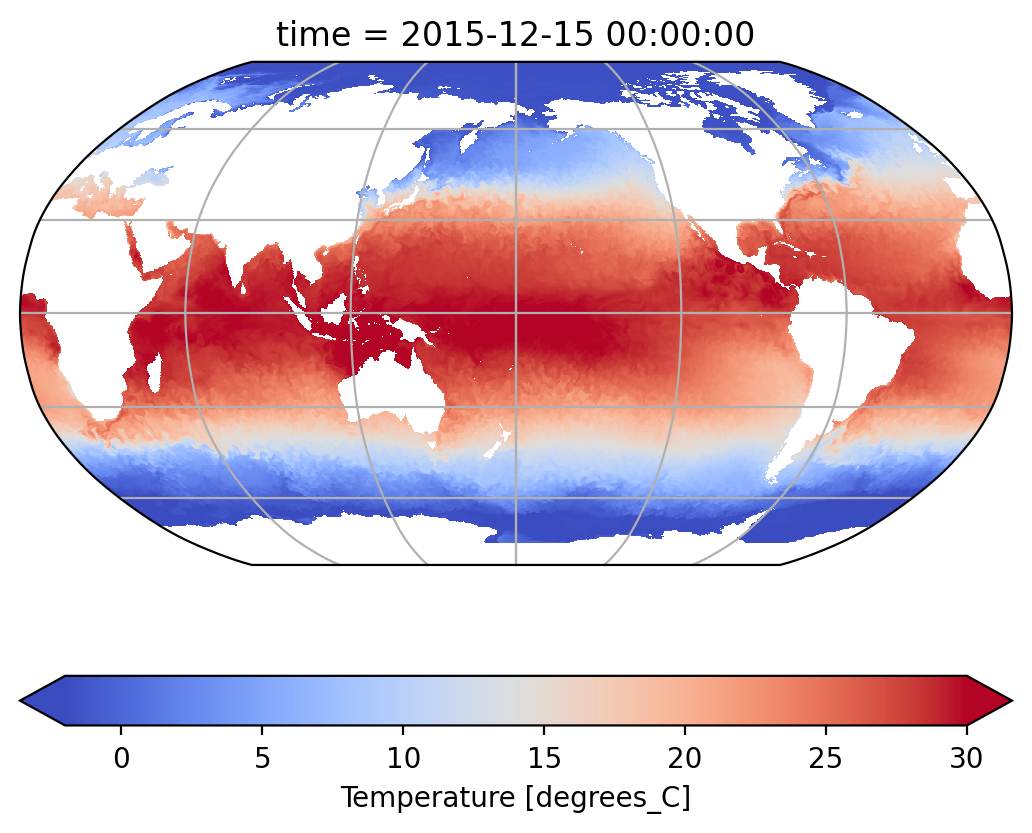

In [15]:
plot(dataset['sst'].sel(time="2015-12-15"))

## Select the Niño 3.4 Region

You may have noticed that the `lon` for the SST data is organized between 0°–360°E.


In [16]:
sst.lon

<xarray.DataArray 'lon' (lon: 1440)> Size: 6kB
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], shape=(1440,), dtype=float32)
Coordinates:
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:  longitude
    units:      degrees_east

This differs from how we typically use `longitude` (-180° to 180°). How do we convert the value of longitude between two systems (0° to 360° v.s. -180° to 180°)?

Let's use `lon2` to refer to the longitude system of 0° to 360° while `lon` refers to the system of -180° to 180°.

Note that 0° to 360° is equivalent to 0° to 180°, -180° to 0°.
In other words, `lon2 = 181°` is the same as `lon = -179°`. Hence, in the western hemisphere, `lon2 = lon + 360`.

Therefore, the Niño 3.4 region should be (-5° to 5°, 190° to 240°) using the `lon2` system.

Now that we have identified the longitude values we need to select, we will select the Niño 3.4 region using the [`.sel()`](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.sel.html) method.


In [17]:
# select just the Niño 3.4 region (note our longitude values are in degrees east) by slicing
nino34 = dataset.sel(lat=slice(-5, 5), lon=slice(190, 240))
nino34

<xarray.Dataset> Size: 1GB
Dimensions:      (lat: 41, lon: 201, time: 10401)
Coordinates:
  * lat          (lat) float32 164B -5.0 -4.75 -4.5 -4.25 ... 4.25 4.5 4.75 5.0
  * lon          (lon) float32 804B 190.0 190.2 190.5 ... 239.5 239.8 240.0
  * time         (time) object 83kB 1993-01-01 00:00:00 ... 2021-06-30 00:00:00
Data variables:
    sst          (time, lat, lon) float32 343MB dask.array<chunksize=(1, 41, 201), meta=np.ndarray>
    climatology  (time, lat, lon) float32 343MB dask.array<chunksize=(1, 41, 201), meta=np.ndarray>
    anomaly      (time, lat, lon) float32 343MB dask.array<chunksize=(1, 41, 201), meta=np.ndarray>
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C
    valid_max:      21306
    valid_min:      -32766

Let's utilize the same code we used to plot the entire Earth, but this time focusing on the Niño 3.4 region slice only.


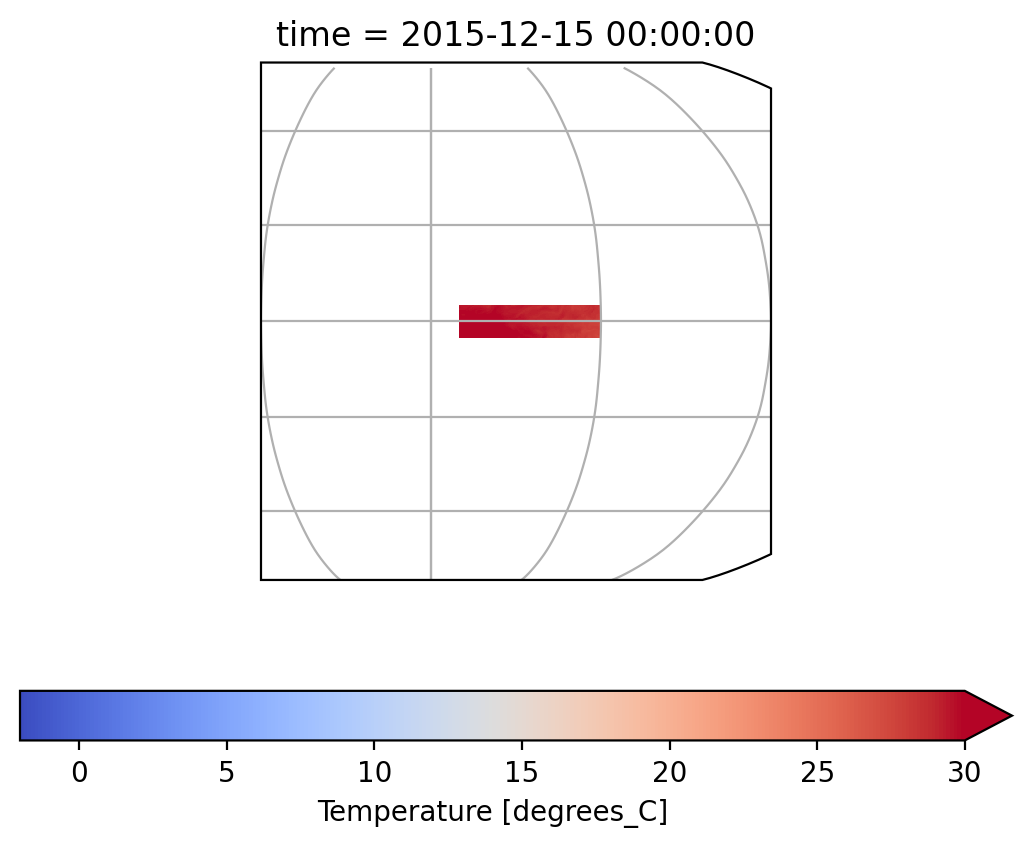

In [18]:
plot(nino34['sst'].sel(time="2015-12-15"), extent=(120, 300, 10, -10))

## Compute the area average of the anomaly

Now that we have selected our area, we can compute the monthly anomaly by first grouping all the data by month, and then subtracting the monthly climatology from each month. Taking the area-weighted average of these anomalies finally results in a time series with a temporal resolution of months.


In [19]:
def get_area_weights(ds: xr.Dataset) -> xr.DataArray:
    _, lats = np.meshgrid(ds['lon'], ds['lat'])
    da = xr.DataArray(data=np.abs(np.cos(lats * np.pi / 180)),
                      dims=('lat', 'lon'),
                      coords=[ds[dim] for dim in ['lat', 'lon']], name='area_weights')
    return da

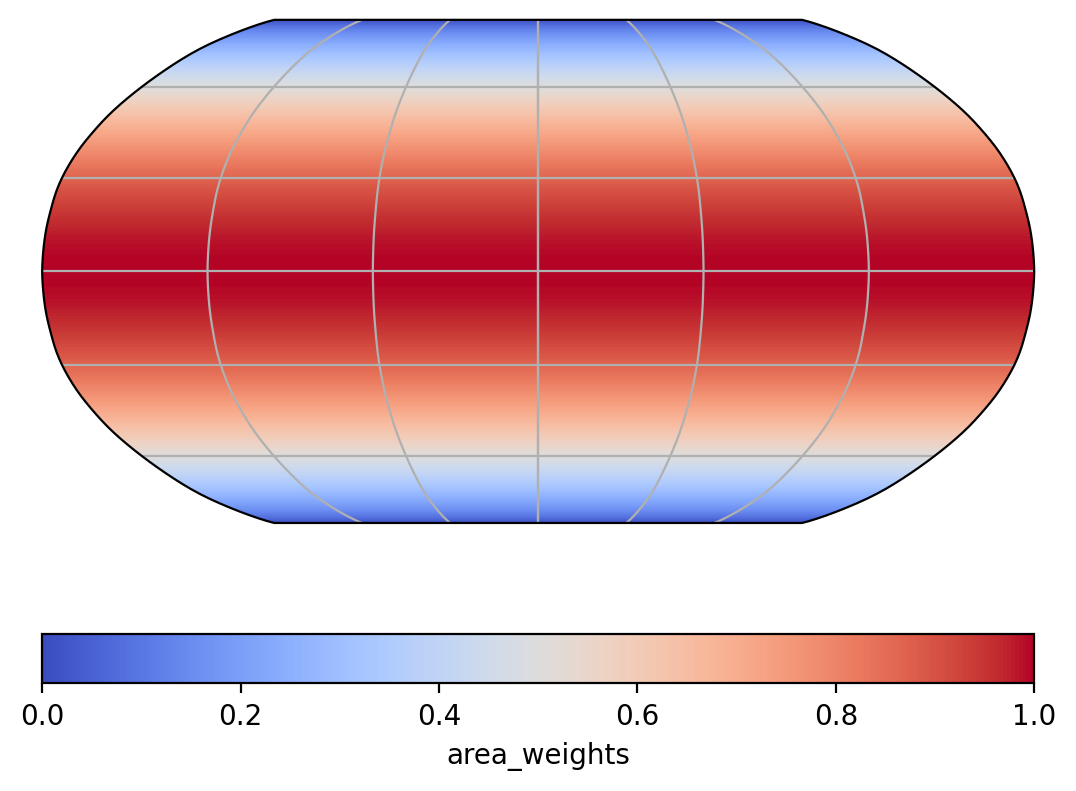

In [20]:
plot(get_area_weights(dataset), vmin=0.0, vmax=1.0)

In [21]:
oni = nino34['anomaly'].weighted(get_area_weights(nino34)).mean(dim=['lat', 'lon'])
oni

<xarray.DataArray 'anomaly' (time: 10401)> Size: 42kB
dask.array<truediv, shape=(10401,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 83kB 1993-01-01 00:00:00 ... 2021-06-30 00:00:00

In [22]:
%time oni = oni.compute()

CPU times: user 1min 13s, sys: 6.75 s, total: 1min 20s
Wall time: 9min 16s


## Smooth the anomaly time series


ENSO occurs on interannual timescales (a few years or more). To isolate the variability of this longer-term phenomenon on the Niño 3.4 region, we can smooth out the fluctuations due to variability on shorter timescales. To achieve this, we will apply a 3-month running mean to our time series of SST anomalies.

In other words, even though we have almost the same amount of values in our time series, one SST anomaly entry now also depends on its neighboring months. The neighboring entries now influence the extremity of, e.g., a peak, by reducing its height in correspondence with their difference to this fluctuation. In summary, this removes short-term deviations and highlights when the signal is sustained over a longer time.

In [23]:
# smooth using a centered 3 month running mean
oni_smoothed = oni.rolling(time=90, center=True).mean()

Text(0.5, 0, 'Time (years)')

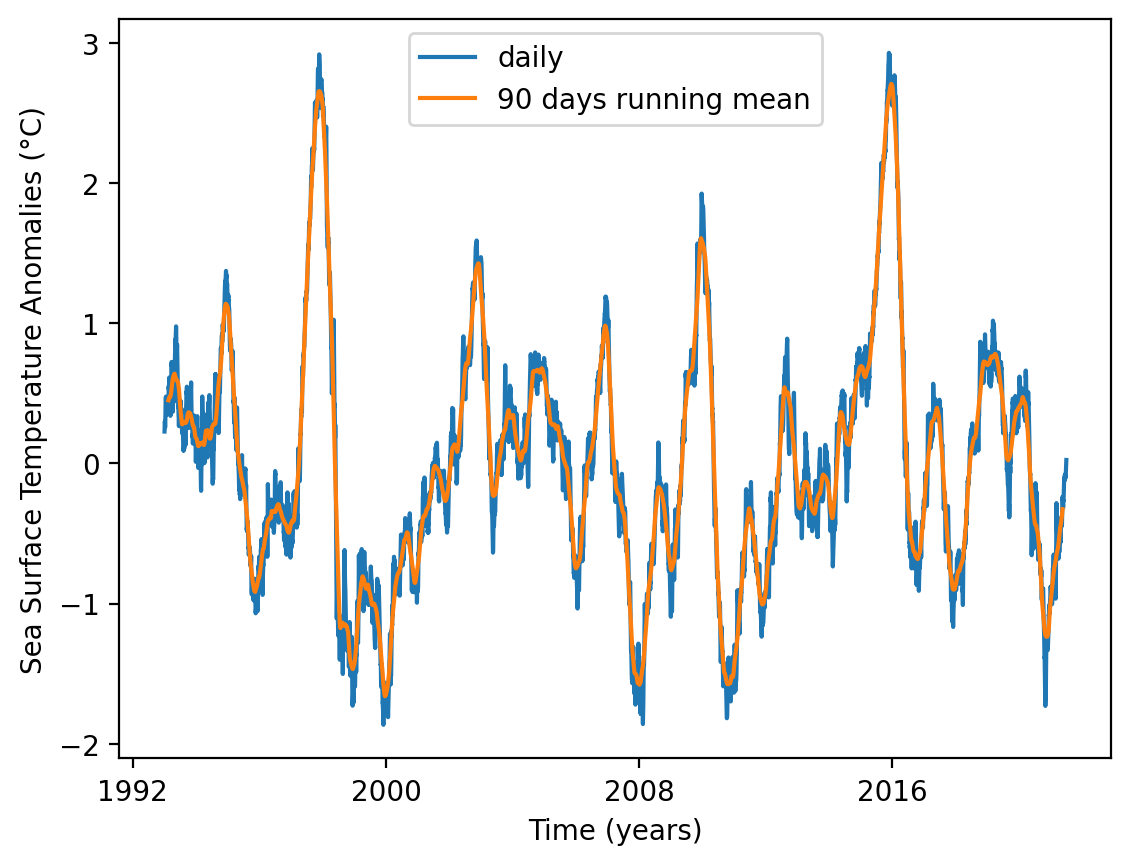

In [24]:
# define the plot size
fig = plt.figure()

# assign axis
ax = plt.axes()

# plot the monhtly data on the assigned axis
oni.plot(ax=ax)

# plot the smoothed data on the assigned axis
oni_smoothed.plot(ax=ax)

# add legend
ax.legend(["daily", "90 days running mean"])

# add ylabel
ax.set_ylabel("Sea Surface Temperature Anomalies (°C)")

# add xlabel
ax.set_xlabel("Time (years)")

# Plot the time series and identify El Niño and La Niña events


We will highlight values in excess of $\pm$0.5, roughly corresponding to El Niño (warm) and La Niña (cold) events.


Text(0, 0.5, 'Sea Surface Temperature Anomalies (°C)')

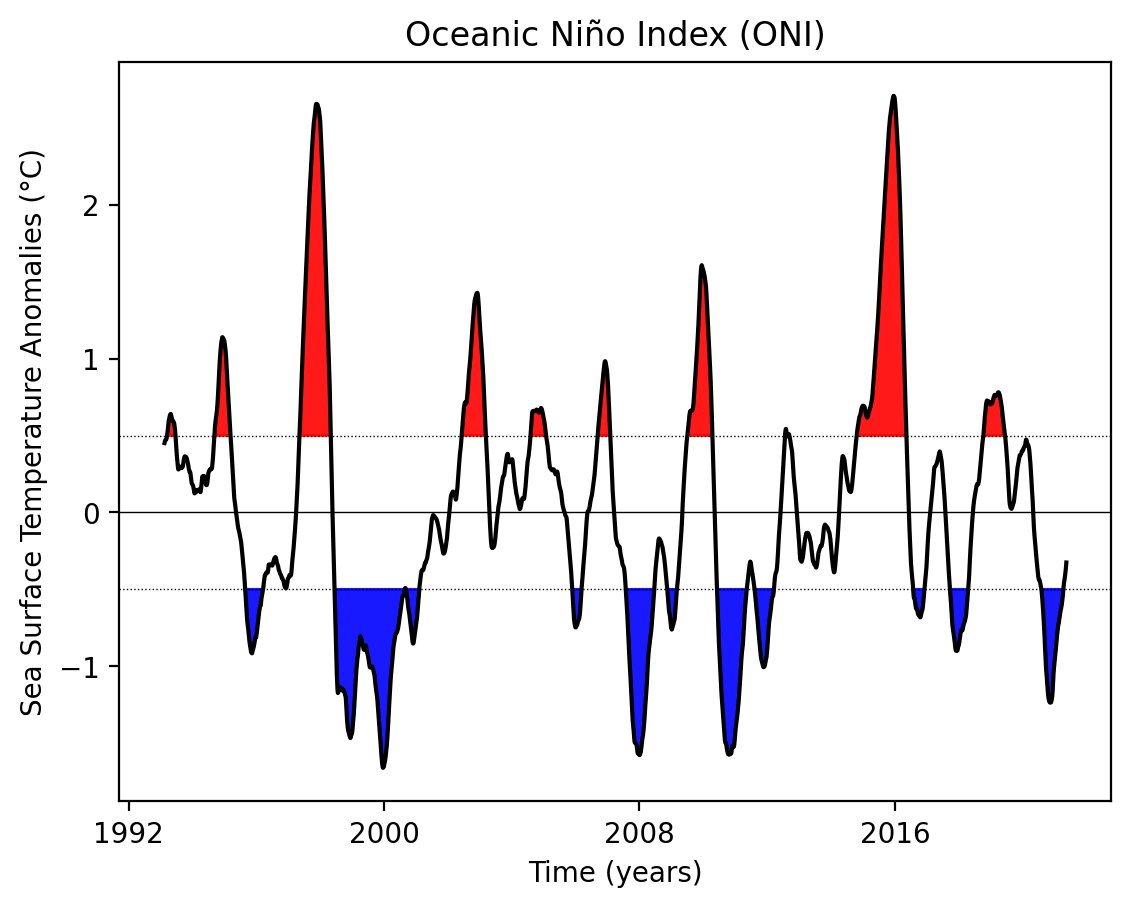

In [25]:
fig = plt.figure()

plt.fill_between(  # plot with color in between
    oni_smoothed.time.data,  # x values
    # top boundary - y values above or equal 0.5
    oni_smoothed.where(oni_smoothed >= 0.5).data,
    0.5,            # bottom boundary - 0.5
    color = "red",  # color
    alpha = 0.9,    # transparency value
)
plt.fill_between(
    oni_smoothed.time.data,
    oni_smoothed.where(oni_smoothed <= -0.5).data,
    -0.5,
    color = "blue",
    alpha = 0.9,
)

oni_smoothed.plot(color="black")          # plot the smoothed data
plt.axhline(0, color="black", lw = 0.5)  # add a black line at x=0
plt.axhline(
    0.5, color="black", linewidth = 0.5, linestyle="dotted"
)  # add a black line at x = 0.5
plt.axhline(
    -0.5, color="black", linewidth = 0.5, linestyle="dotted"
)  # add a black line at x = -0.5

# aesthetics
plt.title("Oceanic Niño Index (ONI)")
plt.xlabel('Time (years)')
plt.ylabel("Sea Surface Temperature Anomalies (°C)")

In [26]:
client.shutdown()

2025-11-04 15:06:44,801 - distributed.core - INFO - Received 'close-stream' from tcp://127.0.0.1:41945; closing.
2025-11-04 15:06:44,801 - distributed.core - INFO - Received 'close-stream' from tcp://127.0.0.1:41945; closing.
2025-11-04 15:06:44,801 - distributed.core - INFO - Received 'close-stream' from tcp://127.0.0.1:41945; closing.
2025-11-04 15:06:44,801 - distributed.core - INFO - Received 'close-stream' from tcp://127.0.0.1:41945; closing.
